In [1]:
%load_ext autoreload
%autoreload 2

# Results Figures Replications

This notebook contains the necessary code to replicate the following plots in the paper:
 - Fig 2B: Results for Conifers
 - Supplementary Figure 1: Results for other land types (Shrublands, Conifer-Hardwood)
 - Supplementary Figure 2: Standarized Differences for all land types
 - Supplementary Figure 3: Loss optimization example
 - Supplementary Figure 4: Pooling and Inference
 - Supplementary Figure 5: Severity/Intensity Classes distributions along land types. 
 - Supplementary Figure 6: ATT estimation

In [2]:
import os
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm
from prescribed.build.build_data import classify_dnbr, classify_frp
from prescribed.estimate.calculate_estimator import calculate_estimator
from prescribed.plot import plot_outcomes, plot_std_diffs, template_plots
from prescribed.utils import prepare_template
from tqdm import tqdm

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Make fonts compatible with illustrator
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# Set colors for each land type and measurement
colors_land_type = {
    "conifers": "#7fc97f",
    "shrublands": "#beaed4",
    "hardwood": "#fdc086",
    "conifer-hardwood": "#386cb0",
    "other": "gray",
}

colors_land_type_int = {
    2: "#7fc97f",
    12: "#beaed4",
    8: "#fdc086",
    3: "#386cb0",
}

colors_measurement = {
    "severity": "Greens",
    "intensity": "Oranges",
}

colors_measurement_land_types = {
    "conifers": "Greens",
    "conifer-hardwood": "Oranges",
    "hardwood": "Blues",
    "shrublands": "Purples",
}

# Should all results and plots be pooled? This is the default for the paper
# reults, but can be turned off to replicate other plots where we show no pooling
pooling = True

## Supplementary Figure 5: Severity/Intensity Classes distributions along land types.

In [3]:
dnbr_type = "gee_inmediate"
data_path = "/mnt/sherlock/oak/prescribed_data/processed"
dnbr = pd.read_feather(
    os.path.join(data_path, f"dnbr_{dnbr_type}", "dnbr_long.feather")
)
frp = pd.read_feather(
    os.path.join(data_path, "frp_nominal_conf", "frp_concat.feather")
)

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Load MTBS to give years to the DNBR data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)
mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)
dnbr = dnbr.merge(land_type, on="grid_id", how="left")
frp = frp.merge(land_type, on="grid_id", how="left")

raw_dnbr = classify_dnbr(dnbr)
raw_frp = classify_frp(frp)

/tmp/ipykernel_3234844/3128327661.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data_var]["land_type"] = np.where(


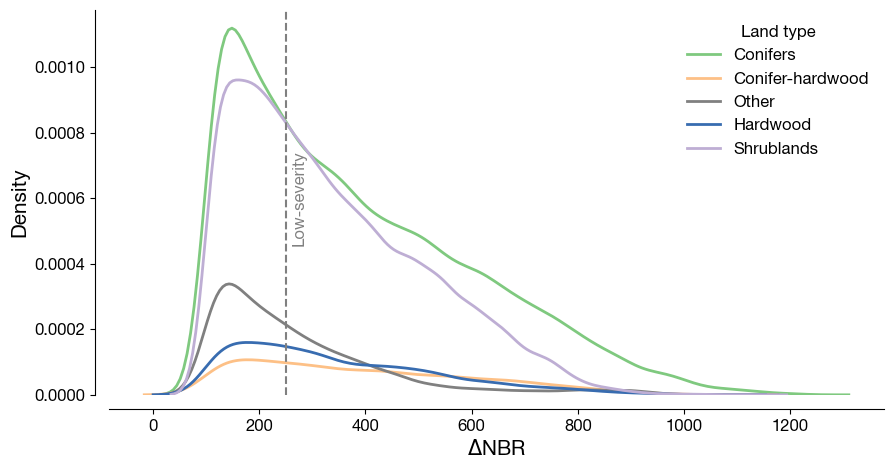

In [4]:
land_types = {
    2: "conifers",
    12: "shrublands",
    3: "conifer-hardwood",
    8: "hardwood",
}
data = {
    "dnbr": raw_dnbr[(raw_dnbr.class_dnbr > 0)],
    "frp": raw_frp[(raw_frp.frp > 0)],
}

colors_land_type_int = {
    "2.0": "#7fc97f",
    "12.0": "#beaed4",
    "8.0": "#fdc086",
    "3.0": "#386cb0",
    "other": "gray",
}

# Do the actual plotting. Add "frp" to names_data to plot FRP too
names_data = ["dnbr"]

fig, ax = plt.subplots(1, len(names_data), figsize=(10, 5))
ax = ax.flatten() if len(names_data) > 1 else [ax]


for idx, (data_var, ax) in enumerate(zip(names_data, ax)):
    # Recode all other land types as "other"
    data[data_var]["land_type"] = np.where(
        data[data_var]["land_type"].isin(land_types.keys()),
        data[data_var]["land_type"],
        "other",
    )

    sns.kdeplot(
        data=data[data_var],
        x=data_var,
        hue="land_type",
        palette=colors_land_type_int,
        linewidth=2,
        ax=ax,
        legend=True if data_var == "dnbr" else True,
    )
    template_plots(
        ax=ax,
        ylab="Density",
        xlab=r"$\Delta$NBR" if data_var == "dnbr" else "FRP",
        axis_text=12,
        label_axis=15,
        vert=250 if data_var == "dnbr" else 100,
        label_vert_pos=(290, 0.0006) if data_var == "dnbr" else (500, 0.0020),
        label_vert="Low-severity" if data_var == "dnbr" else "Low-intensity",
    )

# Rename legend and legend labels
ax.legend(
    title="Land type",
    loc="upper right",
    labels=[
        "Conifers",
        "Conifer-hardwood",
        "Other",
        "Hardwood",
        "Shrublands",
    ],
    frameon=False,
)

# Save to PDF
plt.savefig(
    "../figs/dnbr_all_density.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=400,
)

In [5]:
template = prepare_template(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Merge land types
template = template.merge(land_type, on="grid_id", how="left")
template_conifers = template[template.land_type == 2.0]
template_conifers = template_conifers.merge(
    dnbr, on=["grid_id", "year"], how="left"
)
template_conifers = template_conifers[["grid_id", "dnbr", "year"]]

template_conifers = template_conifers.assign(
    **{
        "dnbr": template_conifers["dnbr"].fillna(0),
        "fire": np.where(template_conifers["dnbr"] > 0, 1, 0),
    }
)

template_conifers = template_conifers.groupby(
    ["year"], as_index=False
).fire.sum()
template_conifers["fire"] = template_conifers["fire"] / 103475

In [39]:
template_conifers.to_csv(
    "../data/results/probability_conifer_fire.csv", index=False
)

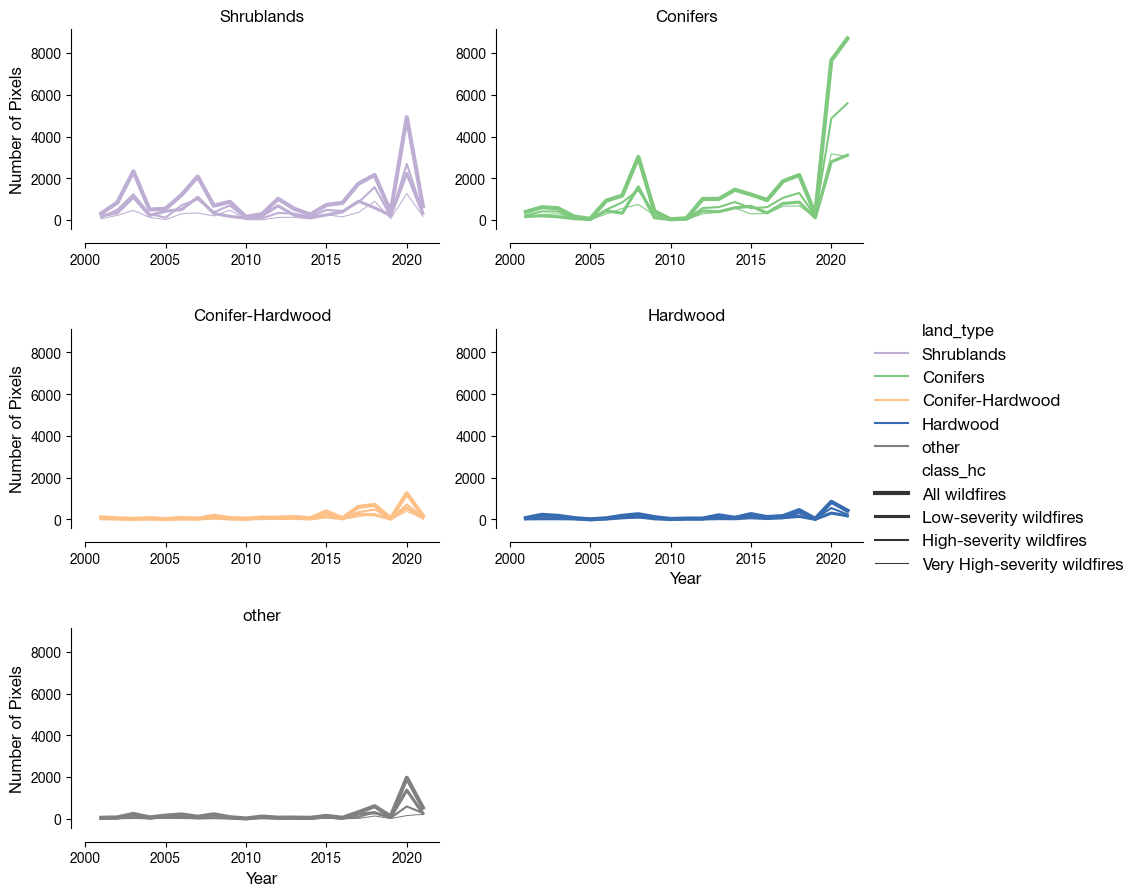

In [ ]:
data_test = data["dnbr"]

land_types = {
    "2.0": "conifers",
    "12.0": "shrublands",
    "3.0": "conifer-hardwood",
    "8.0": "hardwood",
}

data_counts = (
    data_test[data_test.year >= 2000]
    .groupby(["land_type", "class_dnbr", "year"], as_index=False)
    .grid_id.count()
)

hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "Low-severity wildfires": [1],
    "High-severity wildfires": [2, 3, 4],
    "Very High-severity wildfires": [3, 4],
}

data_count_type = []
for hc_name, hc_list in hc_lists.items():
    data_counts = (
        data_test[
            (data_test.year > 2000) & (data_test.class_dnbr.isin(hc_list))
        ]
        .groupby(["land_type", "year"], as_index=False)
        .grid_id.count()
    )
    data_counts["class_hc"] = hc_name
    data_count_type.append(data_counts)

data_count_type = pd.concat(data_count_type)

# Rename columns for plotting
new_vals = [
    v.capitalize()
    if "-" not in v
    else "-".join([s.capitalize() for s in v.split("-")])
    for v in land_types.values()
]

class_dnbr_values = {
    1: "low",
    2: "moderate",
    3: "high",
    4: "very high",
}

land_types = {k: v for k, v in zip(land_types.keys(), new_vals)}
colors_land_type = {
    k: v for k, v in zip(land_types.values(), colors_land_type.values())
}
colors_land_type["other"] = "gray"

data_count_type = data_count_type.replace({"land_type": land_types})

axs = sns.relplot(
    data=data_count_type,
    x="year",
    y="grid_id",
    hue="land_type",
    col="land_type",
    size="class_hc",
    col_wrap=2,
    kind="line",
    palette=colors_land_type,
    height=3,
    aspect=1.5,
    facet_kws={"sharey": True, "sharex": True},
)
sns.despine()
axs.set_titles(col_template="{col_name}")

for ax in axs.axes.flatten():
    template_plots(ax=ax, ylab=r"Number of Pixels", xlab="Year")


# Add space between facets
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# Save to PDF
plt.savefig(
    "../figs/dnbr_class_counts.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=400,
)


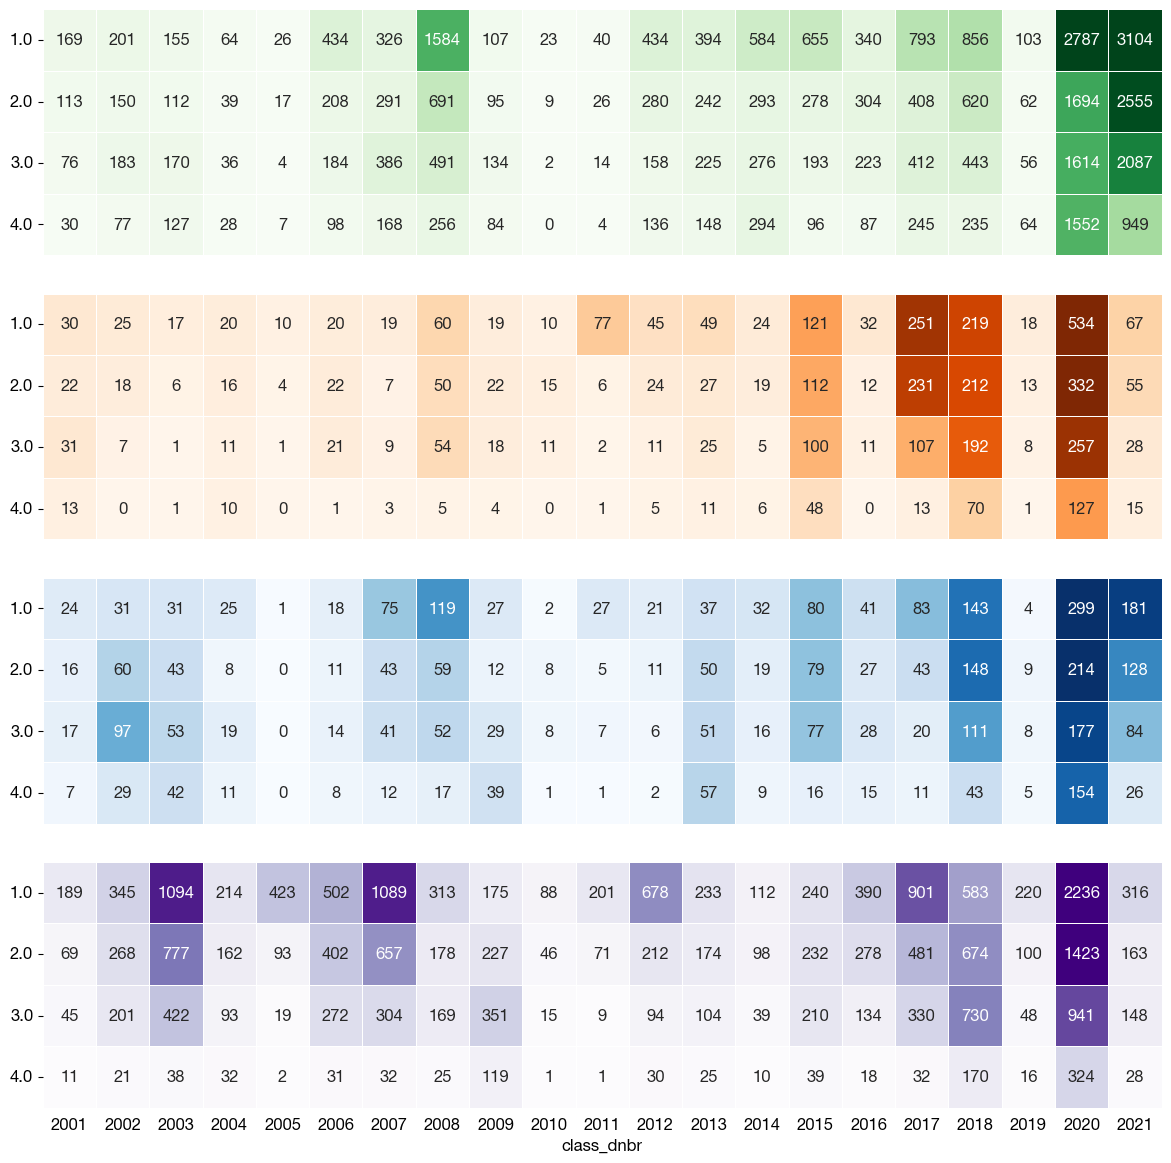

In [49]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop("data")
    color_cmap = kwargs.pop("color")
    d = (
        data[(data.year > 2000) & (data.year <= 2021)]
        .pivot_table(
            index=args[0], columns=args[1], values=args[2], aggfunc="count"
        )
        .fillna(0)
        .astype(int)
    )

    sns.heatmap(
        d,
        annot=True,
        fmt="d",
        cmap=color_cmap,
        linewidths=0.5,
        robust=True,
        cbar=False,
    )


data_test = data["dnbr"]
fg = sns.FacetGrid(
    data_test,
    row="land_type",
    hue="land_type",
    hue_kws={"color": ["Greens", "Oranges", "Blues", "Purples"]},
    aspect=4,
    sharex=True,
)
fg.map_dataframe(
    draw_heatmap,
    "class_dnbr",
    "year",
    "dnbr",
)

for ax in fg.axes.flatten():
    ax.title.set_text("")

    # Make y-axis tick labels horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    # Set the y-axis label
    ax.set_ylabel("")

    # Remove ticks on the x-axis, but keep labels
    ax.tick_params(axis="x", which="both", bottom=False, top=False)


## Figures involving weighting/balancing (Fig 1B, Sup Fig 1 - 4)

To run the following blocks, you need to make sure to have all the weightning files from the optimization process and model selection done by tyra. Once that is done, you can load the standarized difference files and the weights using the criteria you desire (`loss` or `asmd`). 

In [5]:
# Load MTBS to give years to the DNBR data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year


# Load land types to merge treatments with land type
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Load all treatments
wide_treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_mtbs.feather"
).merge(land_type, on="grid_id", how="left")

wide_treatments_inmediate = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather"
).merge(land_type, on="grid_id", how="left")

wide_treatments_frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_frp.feather"
).merge(land_type, on="grid_id", how="left")

# Load the dnbr data and merge with MTBS to get years.
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)

In [6]:
criteria = (
    "loss"  # Doesn't matter! We use loss or asmd, both have the same targets
)

results_dir = "../tyra/mtbs_treatments_results"
results_shrubs = "../tyra/mtbs_treatments_results_inmediate"
results_frp = "../tyra/frp_treatments_results/"

conifers_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_std_diffs.csv"
    ),
}

shrubs_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_shrubs}/dnbr_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_shrubs}/dnbr_treat_shrubs/best_model_{criteria}_std_diffs.csv"
    ),
}

hardwood_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_hardwood/best_model_{criteria}_std_diffs.csv"
    ),
}

hc_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_coniferhardwood/best_model_{criteria}_std_diffs.csv"
    ),
}


## Supplementary Figure 2: Standarized Differences  

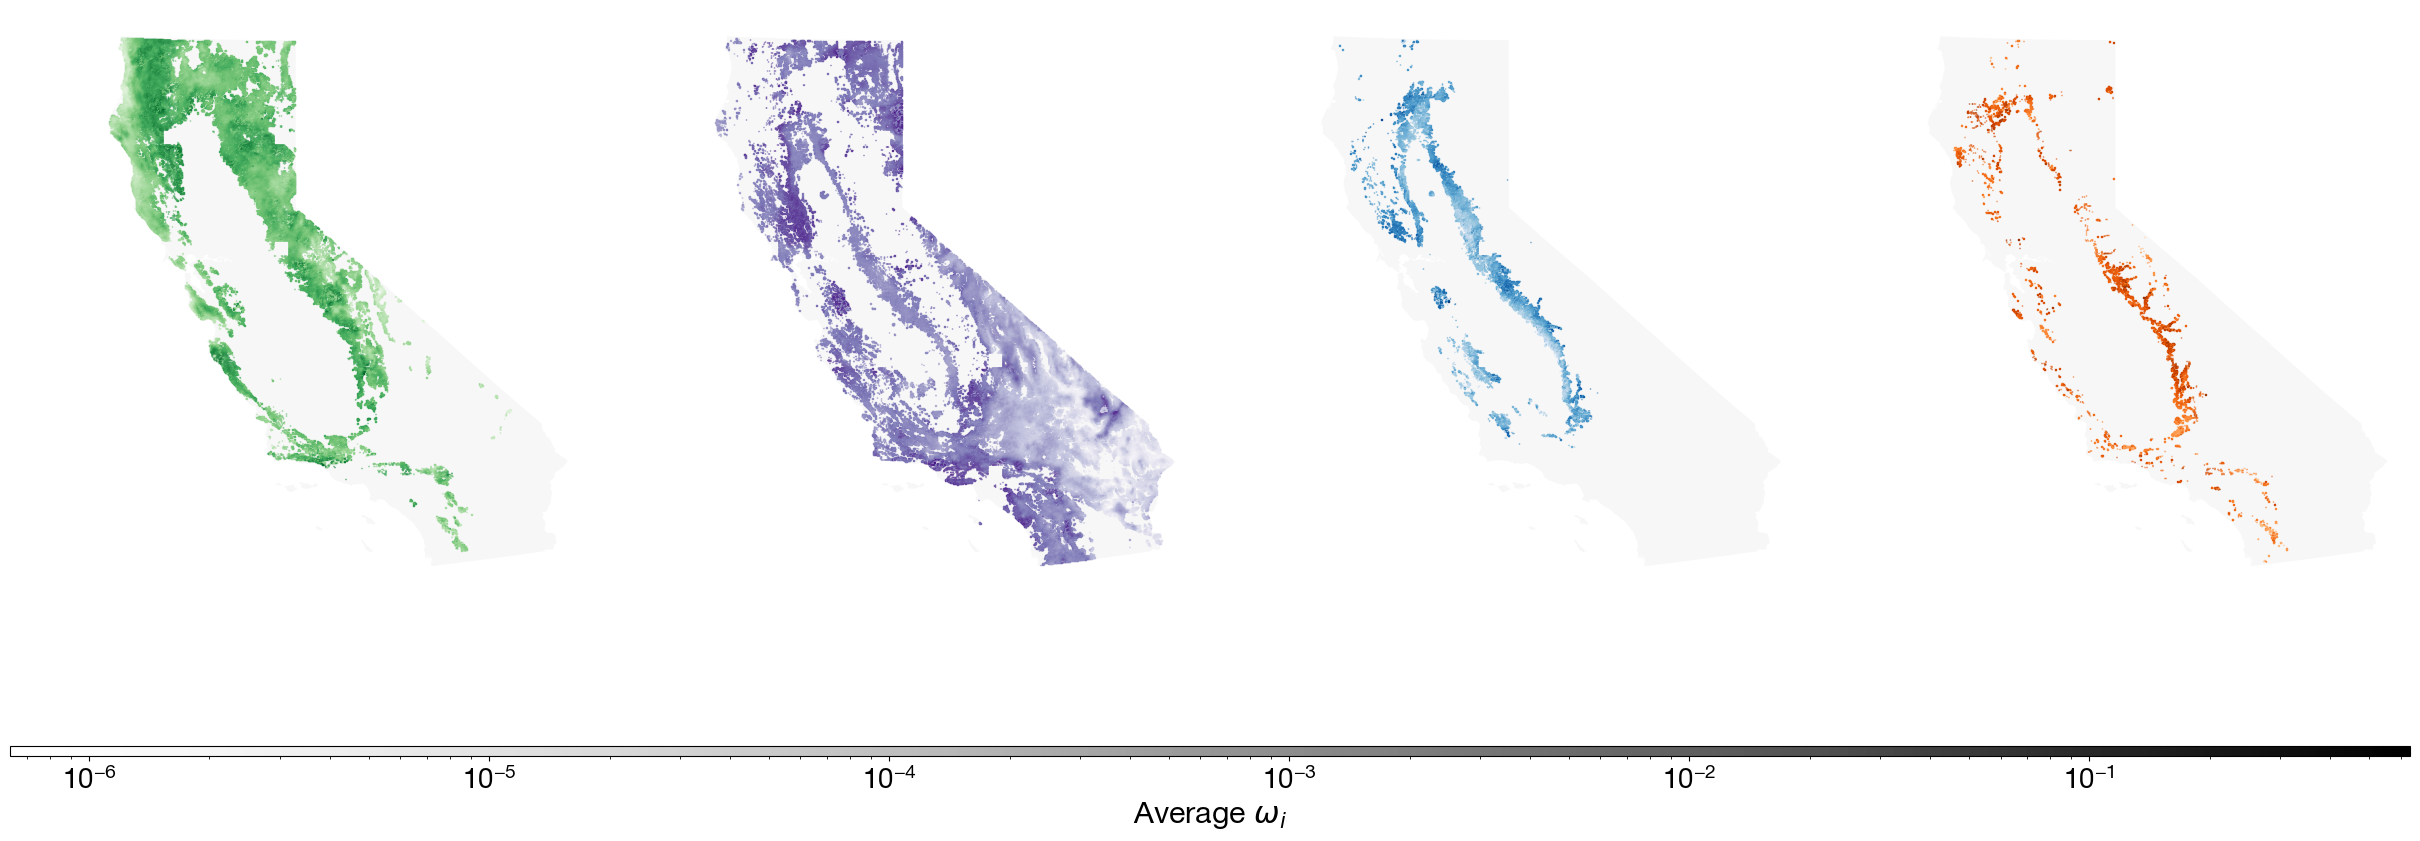

In [10]:
# Set the font size to be 12
plt.rcParams["font.size"] = 20

# Load template to plot the weights in space and load the CA shapefile to do
# a nice plot
template = (
    prepare_template(
        "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
    )
    .groupby("grid_id", as_index=False)
    .first()
    .drop(columns=["year"])
)

ca = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("3310")


fig, ax = plt.subplots(1, 4, figsize=(30, 10))
colors = ["Greens", "Purples", "Blues", "Oranges"]
min_list = []
max_list = []


for df_weights, color, ax in zip(
    [
        conifers_loss["weights_dnbr"],
        shrubs_loss["weights_dnbr"],
        hc_loss["weights_dnbr"],
        hardwood_loss["weights_dnbr"],
    ],
    colors,
    ax.flatten(),
):
    weights = df_weights.merge(template, on="grid_id")
    weights = weights.groupby(["grid_id", "lat", "lon"], as_index=False)[
        "weights"
    ].mean()

    weights = gpd.GeoDataFrame(
        weights,
        geometry=gpd.points_from_xy(weights.lon, weights.lat),
        crs="EPSG:3310",
    )

    # Plot conifer weights
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("bottom", size="1%", pad=0.1)

    # Store min and max
    min_list.append(weights["weights"].min())
    max_list.append(weights["weights"].max())

    norm = norm = LogNorm(
        vmin=weights["weights"].min(), vmax=weights["weights"].max()
    )

    ca.plot(ax=ax, color="#d9d9d9", alpha=0.2)

    weights.plot(
        ax=ax,
        column="weights",
        cmap=color,
        norm=norm,
        legend=False,
        marker=",",
        rasterized=True,
        markersize=0.1,
    )
    # Remove the axis labels and lines
    template_plots(ax, no_axis=True, ylab="", xlab="")

# Add a colorbar at the bottom outside the plot using the max and min of all the data
fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.1, -0.01, 0.8, 0.01])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=LogNorm(vmin=min(min_list), vmax=max(max_list))
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label(r"Average $\omega_{i}$", fontsize=22)

# Save as a PDF
plt.savefig(
    "../figs/weights_dnbr_average_all.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=400,
)

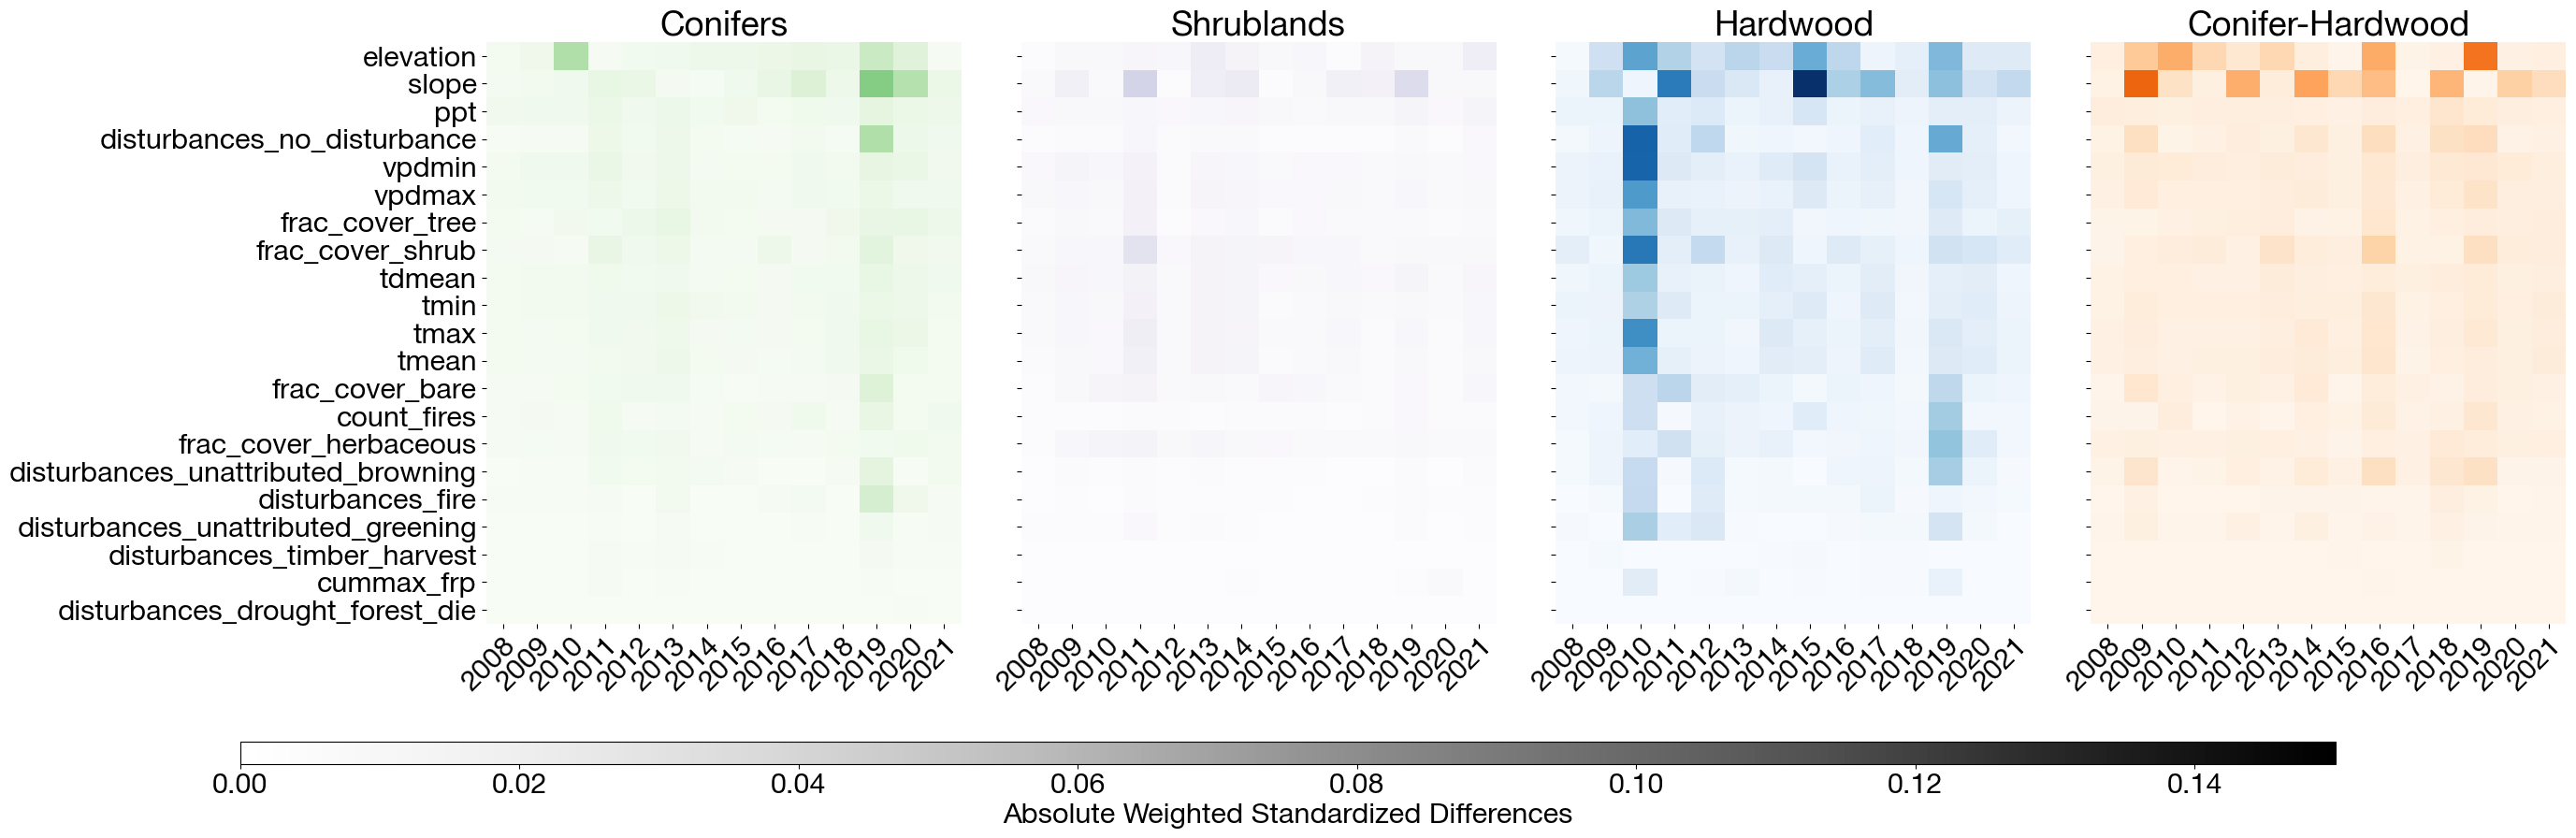

In [11]:
# Set the font size to be 12
plt.rcParams["font.size"] = 22

# Plot Standarized Differences
fig, ax = plt.subplots(1, 4, figsize=(28, 8), sharey=True, layout="tight")
omit = ["Intercept", "land_type", "aspect", "curvature"]

min_list = []
max_list = []

_, std_min, std_max = plot_std_diffs(
    conifers_loss["std_diffs_dnbr"],
    drop_vars=omit,
    draw_cbar=False,
    ax=ax[0],
    palette="Greens",
    sorted=False,
    vmax=0.15010661,
)
min_list.append(std_min)
max_list.append(std_max)

# Add title
ax[0].set_title("Conifers")

_, std_min, std_max = plot_std_diffs(
    shrubs_loss["std_diffs_dnbr"],
    drop_vars=omit,
    draw_cbar=False,
    ax=ax[1],
    palette="Purples",
    sorted=False,
    vmax=0.15010661,
)
min_list.append(std_min)
max_list.append(std_max)

# Add title
ax[1].set_title("Shrublands")

_, std_min, std_max = plot_std_diffs(
    hardwood_loss["std_diffs_dnbr"],
    drop_vars=omit,
    draw_cbar=False,
    ax=ax[2],
    palette="Blues",
    sorted=False,
    vmax=0.15010661,
)
min_list.append(std_min)
max_list.append(std_max)

# Add title
ax[2].set_title("Hardwood")

_, std_min, std_max = plot_std_diffs(
    hc_loss["std_diffs_dnbr"],
    drop_vars=omit,
    draw_cbar=False,
    ax=ax[3],
    palette="Oranges",
    sorted=False,
    vmax=0.15010661,
)
min_list.append(std_min)
max_list.append(std_max)

# Add title
ax[3].set_title("Conifer-Hardwood")

# Add a colorbar at the bottom outside the plot using the max and min of all the data
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=min(min_list), vmax=max(max_list))
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Absolute Weighted Standardized Differences", fontsize=22)

# Save plot as PDF
plt.savefig(
    "../figs/standarized_diffs_all_land_types.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=400,
    pad_inches=0.1,
)

## Fig 2B and Supplementary Figure 1: Relative Risk Ratio results for all land types

In [13]:
# Be careful, this takes time for RR. We calculate for all the land types and classes.
warnings.filterwarnings("ignore")

list_results = []
hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "High-intensity wildfires": [3, 4, 5],
    "High-severity wildfires": [2, 3, 4],
    "Very High-intensity wildfires": [4, 5],
    "Very High-severity wildfires": [3, 4],
}

for key, high_class in tqdm(hc_lists.items()):
    if key == "All wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments
    elif key == "Very High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "Very High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments

    rr_conifer = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 2],
        weights=conifers_loss[f"weights_{treat_var}"],
        outcomes="rr",
        focal_years=range(2008, 2022),
        outcome_var=None,
        low_treatment_class={treat_var if key != "All wildfires" else "frp": 1},
        pooling=pooling,
        high_class=high_class,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_count",
        max_lags=14,
        rr=True,
    )
    rr_conifer["high_class"] = key
    rr_conifer["land_type"] = "conifers"
    list_results.append(rr_conifer)

    rr_hardwood = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 8],
        weights=hardwood_loss[f"weights_{treat_var}"],
        outcomes="rr",
        focal_years=range(2008, 2022),
        outcome_var=None,
        low_treatment_class={treat_var if key != "All fires" else "frp": 1},
        pooling=pooling,
        high_class=high_class,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_count",
        max_lags=12,
        rr=True,
    )
    rr_hardwood["high_class"] = key
    rr_hardwood["land_type"] = "hardwood"
    list_results.append(rr_hardwood)

    try:
        rr_hc = calculate_estimator(
            treatments=treat_df[treat_df.land_type == 3],
            weights=hc_loss[f"weights_{treat_var}"],
            outcomes="rr",
            focal_years=range(2008, 2022),
            outcome_var=None,
            low_treatment_class={treat_var if key != "All fires" else "frp": 1},
            pooling=pooling,
            high_class=high_class,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_count",
            max_lags=12,
            rr=True,
        )
        rr_hc["high_class"] = key
        rr_hc["land_type"] = "conifer-hardwood"
        list_results.append(rr_hc)

    except Exception as e:
        pass
        print(e)
        rr_shrubs = None

    try:
        # Do the same for shrubs
        if key == "High-intensity fires":
            treat_df = wide_treatments_inmediate

        rr_shrubs = calculate_estimator(
            treatments=treat_df[treat_df.land_type == 12],
            weights=shrubs_loss[f"weights_{treat_var}"],
            outcomes="rr",
            focal_years=range(2008, 2022),
            outcome_var=None,
            low_treatment_class={
                treat_var if key != "All wildfires" else "frp": 1
            },
            pooling=pooling,
            high_class=high_class,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_count",
            max_lags=14,
            rr=True,
        )
        rr_shrubs["high_class"] = key
        rr_shrubs["land_type"] = "shrublands"

    except Exception as e:
        pass
        print(e)
        rr_shrubs = None

    list_results.append(rr_shrubs)

Calculating estimator per focal year...: 100%|██████████| 14/14 [00:37<00:00,  2.67s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:02<00:00,  6.08it/s]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:06<00:00,  2.17it/s]
Error in Jackknife estimation: zero-size array to reduction operation maximum which has no identity
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:37<00:00,  2.66s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 10

## Fig 2B: RR for only conifers

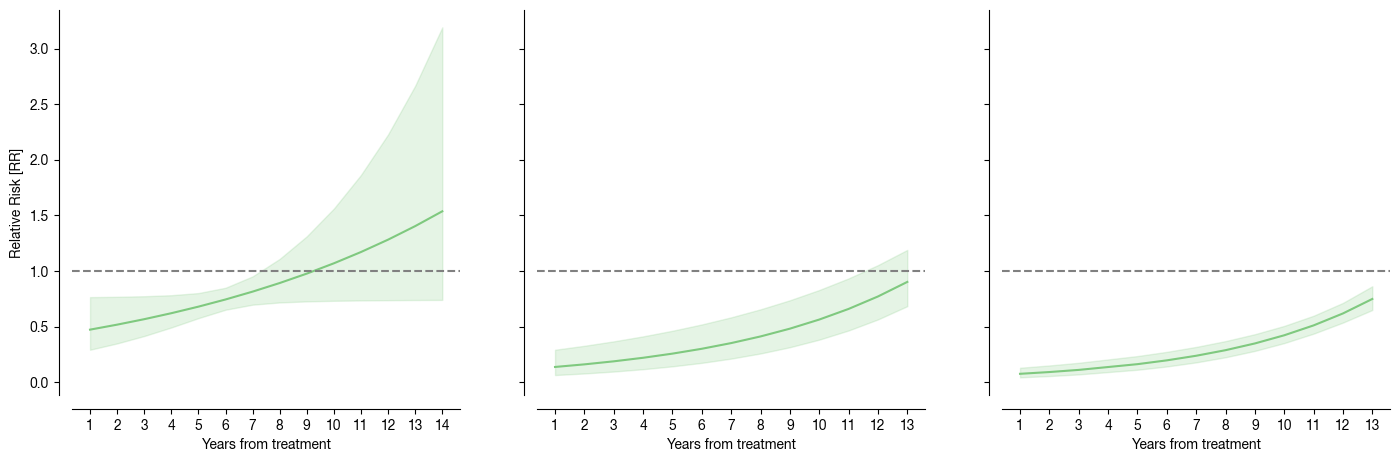

In [14]:
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Set colors for each land type and measurement
colors_land_type = {
    "conifers": "#7fc97f",
    "shrublands": "#beaed4",
    "hardwood": "#fdc086",
    "conifer-hardwood": "#386cb0",
    "other": "gray",
}

# Concatenate list with all results to plot
rrs = pd.concat(list_results)
rrs.sort_values("year", inplace=True)

# Plot coefs and CIs for the different high classes and land types
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

################################################################################
######################### PLOT RELATIVE RISK ESTIMATES #########################
################################################################################

plot_outcomes(
    dfs=[
        rrs[(rrs.high_class == "All wildfires") & (rrs.land_type == "conifers")]
    ],
    labels=["Conifers"],
    legend=False,
    # var_interest="rr",
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[0],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "High-severity wildfires")
            & (rrs.land_type == "conifers")
        ],
    ],
    legend=False,
    labels=[
        "Conifers",
    ],
    # var_interest="rr",
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[1],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)


plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "Very High-severity wildfires")
            & (rrs.land_type == "conifers")
        ],
    ],
    legend=False,
    labels=["Conifers", "Shrublands"],
    # var_interest="rr",
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[2],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

ax[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

# # Save plot
plt.savefig(
    "../figs/fig_results_severity.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Supplementary Figure 1: RR for other land types


In [27]:
(
    1
    - (
        rrs[
            (rrs.high_class == "Very High-severity wildfires")
            & (rrs.land_type == "conifers")
        ].sort_values("year")[["coef", "low_ci", "high_ci", "year"]]
    )
)

,coef,low_ci,high_ci,year
9,0.924347,0.956001,0.869921,0.0
11,0.908426,0.944365,0.849272,-1.0
10,0.889155,0.929676,0.825288,-2.0
0,0.837594,0.887800,0.764920,-4.0
8,0.803416,0.858435,0.727014,-5.0
1,0.762047,0.821593,0.682627,-6.0
2,0.711971,0.775549,0.630384,-7.0
3,0.651358,0.718375,0.568392,-8.0
4,0.577988,0.648137,0.493855,-9.0
7,0.489179,0.563382,0.402364,-10.0


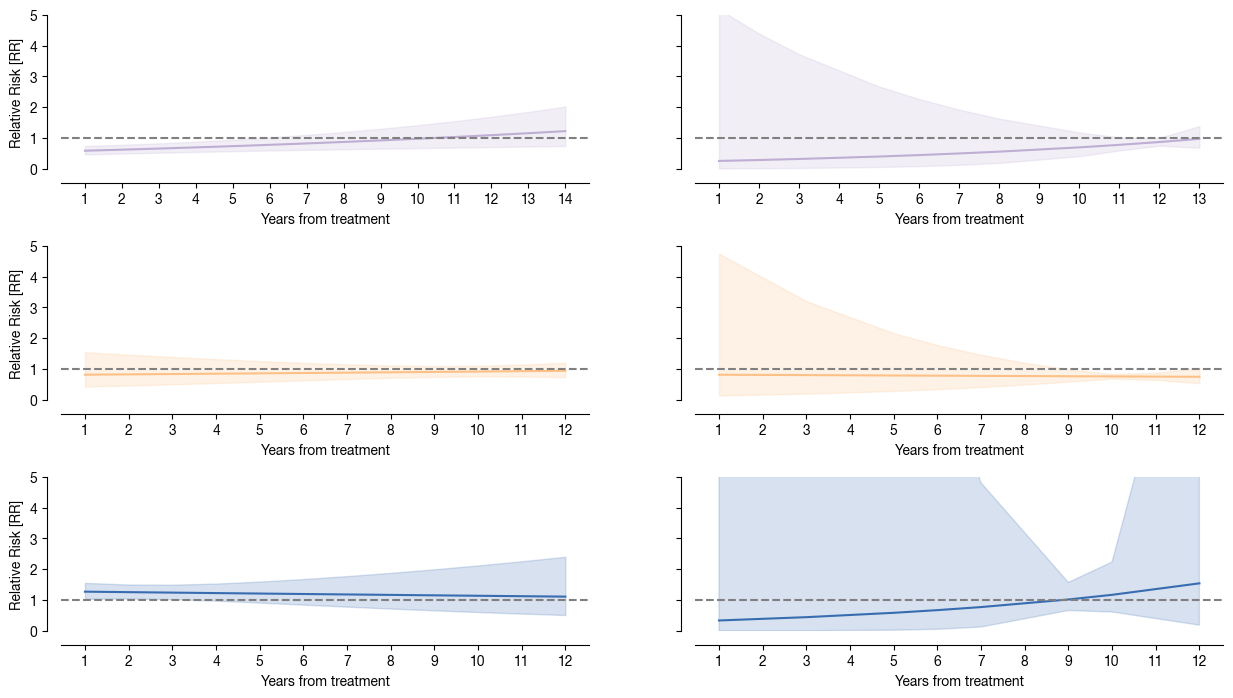

In [12]:
# Plot coefs and CIs for the different high classes and land types
fig, ax = plt.subplots(3, 2, figsize=(15, 8), sharey=True)

################################################################################
######################### PLOT RELATIVE RISK ESTIMATES #########################
################################################################################

plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "All wildfires")
            & (rrs.land_type == "shrublands")
        ]
    ],
    labels=["Shrublands"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[0, 0],
    cmaps=[
        "Purples",
    ],
    colors=[
        colors_land_type["shrublands"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "High-severity wildfires")
            & (rrs.land_type == "shrublands")
        ],
    ],
    legend=False,
    labels=[
        "Shrublands",
    ],
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[0, 1],
    cmaps=[
        "Purples",
    ],
    colors=[
        colors_land_type["shrublands"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)


plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "All wildfires") & (rrs.land_type == "hardwood")
        ],
    ],
    legend=False,
    labels=["Hardwood"],
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[1, 0],
    cmaps=[
        "Blues",
    ],
    colors=[
        colors_land_type["hardwood"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "High-severity wildfires")
            & (rrs.land_type == "hardwood")
        ],
    ],
    legend=False,
    labels=[
        "Hardwood",
    ],
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[1, 1],
    cmaps=[
        "Blues",
    ],
    colors=[
        colors_land_type["hardwood"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)


plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "All wildfires")
            & (rrs.land_type == "conifer-hardwood")
        ],
    ],
    legend=False,
    labels=["Conifer-Hardwood"],
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[2, 0],
    cmaps=[
        "Oranges",
    ],
    colors=[
        colors_land_type["conifer-hardwood"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

plot_outcomes(
    dfs=[
        rrs[
            (rrs.high_class == "High-severity wildfires")
            & (rrs.land_type == "conifer-hardwood")
        ],
    ],
    legend=False,
    labels=["Conifer-Hardwood"],
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[2, 1],
    cmaps=[
        "Oranges",
    ],
    colors=[
        colors_land_type["conifer-hardwood"],
    ],
    pooled=pooling,
    axis_text=10,
    label_axis=10,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

# Cut y-axis from 0 to 5 to make it more readable
ax[2, 1].set_ylim(0, 5)

# Add space between facets
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# Save plot
plt.savefig(
    "../figs/fig_results_severity_all_types.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

## Supplementary Figure 4: Pooling estimates

In [7]:
pooling = False

# Be careful, this takes time for RR. We calculate for all the land types and classes.
warnings.filterwarnings("ignore")

list_results = []
hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "High-intensity wildfires": [3, 4, 5],
    "High-severity wildfires": [2, 3, 4],
    "Very High-intensity wildfires": [4, 5],
    "Very High-severity wildfires": [3, 4],
}

for key, high_class in tqdm(hc_lists.items()):
    if key == "All wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments
    elif key == "Very High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "Very High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments

    rr_conifer = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 2],
        weights=conifers_loss[f"weights_{treat_var}"],
        outcomes="rr",
        focal_years=range(2008, 2022),
        outcome_var=None,
        low_treatment_class={treat_var if key != "All wildfires" else "frp": 1},
        pooling=pooling,
        high_class=high_class,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_count",
        max_lags=12,
        rr=True,
    )
    rr_conifer["high_class"] = key
    rr_conifer["land_type"] = "conifers"
    list_results.append(rr_conifer)

    rr_hardwood = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 8],
        weights=hardwood_loss[f"weights_{treat_var}"],
        outcomes="rr",
        focal_years=range(2008, 2022),
        outcome_var=None,
        low_treatment_class={treat_var if key != "All fires" else "frp": 1},
        pooling=pooling,
        high_class=high_class,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_count",
        max_lags=12,
        rr=True,
    )
    rr_hardwood["high_class"] = key
    rr_hardwood["land_type"] = "hardwood"
    list_results.append(rr_hardwood)

    try:
        rr_hc = calculate_estimator(
            treatments=treat_df[treat_df.land_type == 3],
            weights=hc_loss[f"weights_{treat_var}"],
            outcomes="rr",
            focal_years=range(2008, 2022),
            outcome_var=None,
            low_treatment_class={treat_var if key != "All fires" else "frp": 1},
            pooling=pooling,
            high_class=high_class,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_count",
            max_lags=12,
            rr=True,
        )
        rr_hc["high_class"] = key
        rr_hc["land_type"] = "conifer-hardwood"
        list_results.append(rr_hc)

    except Exception as e:
        pass
        print(e)
        rr_shrubs = None

    try:
        # Do the same for shrubs
        if key == "High-intensity fires":
            treat_df = wide_treatments_inmediate

        rr_shrubs = calculate_estimator(
            treatments=treat_df[treat_df.land_type == 12],
            weights=shrubs_loss[f"weights_{treat_var}"],
            outcomes="rr",
            focal_years=range(2008, 2022),
            outcome_var=None,
            low_treatment_class={
                treat_var if key != "All wildfires" else "frp": 1
            },
            pooling=pooling,
            high_class=high_class,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_count",
            max_lags=12,
            rr=True,
        )
        rr_shrubs["high_class"] = key
        rr_shrubs["land_type"] = "shrublands"

    except Exception as e:
        pass
        print(e)
        rr_shrubs = None

    list_results.append(rr_shrubs)

  0%|          | 0/5 [00:00<?, ?it/s]

Calculating estimator per focal year...: 100%|██████████| 14/14 [00:37<00:00,  2.66s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:06<00:00,  2.20it/s]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:37<00:00,  2.67s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...:

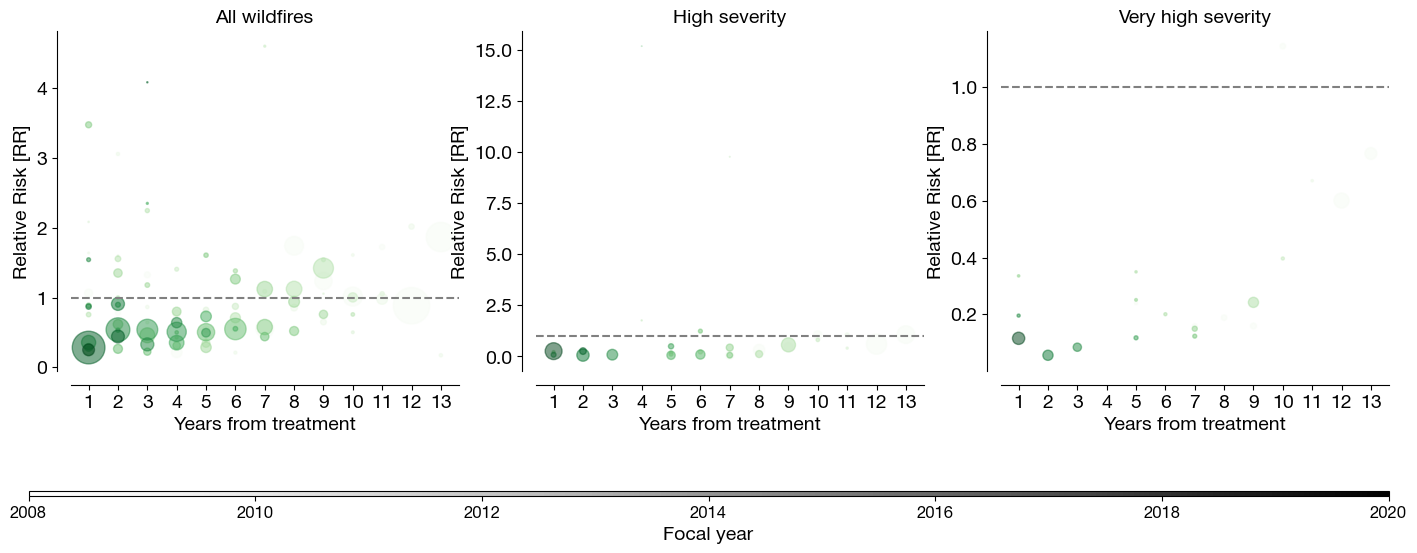

In [8]:
# Set the font size to be 12
plt.rcParams["font.size"] = 15

rrs_no_pooling = pd.concat(list_results)
fig, ax = plt.subplots(1, 3, figsize=(17, 5), sharey=False)

plot_outcomes(
    dfs=[
        rrs_no_pooling[
            (rrs_no_pooling.high_class == "All wildfires")
            & (rrs_no_pooling.land_type == "conifers")
            & (rrs_no_pooling.lag <= 13)
        ]
    ],
    labels=["Shrublands"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[0],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)
ax[0].set_title("All wildfires", fontsize=14)

plot_outcomes(
    dfs=[
        rrs_no_pooling[
            (rrs_no_pooling.high_class == "High-severity wildfires")
            & (rrs_no_pooling.land_type == "conifers")
        ]
    ],
    labels=["Shrublands"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[1],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)
ax[1].set_title("High severity", fontsize=14)

plot_outcomes(
    dfs=[
        rrs_no_pooling[
            (rrs_no_pooling.high_class == "Very High-severity wildfires")
            & (rrs_no_pooling.land_type == "conifers")
        ]
    ],
    labels=["Shrublands"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"Relative Risk [RR]",
    ),
    ax=ax[2],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=pooling,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)
ax[2].set_title("Very high severity", fontsize=14)

# Add a colorbar at the bottom outside the plot using the max and min of all the focal years
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.01])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=2008, vmax=2020)
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Focal year", fontsize=14)

# Resize the colorbar ticks
cbar.ax.tick_params(labelsize=12)

# Save plot as a PDF
plt.savefig(
    "../figs/fig_results_conifer_severity_no_pooling.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)


## Supplmentary Figure 3: ATT estimation with and without pooling


In [40]:
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)

# dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

treat_var = "dnbr"  # Estimate severity, if you want to estimate intensity, change to "frp"
treat_df = wide_treatments_inmediate
formula = "att ~ lag + I(lag ** 2)"

warnings.filterwarnings("ignore")

list_results = []
att_conifer = calculate_estimator(
    treatments=treat_df[treat_df.land_type == 2],
    weights=conifers_loss[f"weights_{treat_var}"],
    outcomes=dnbr.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="dnbr",
    pooling=False,
    cluster_var="year",
    formula=formula,
    max_lags=12,
    rr=False,
)
att_conifer["land_type"] = "conifers"
list_results.append(att_conifer)

att_hardwood = calculate_estimator(
    treatments=treat_df[treat_df.land_type == 2],
    weights=hardwood_loss[f"weights_{treat_var}"],
    outcomes=dnbr.dropna(),
    focal_years=range(2008, 2022),
    outcome_var="dnbr",
    pooling=True,
    cluster_var="year",
    formula=formula,
    max_lags=12,
    rr=False,
)
att_hardwood["land_type"] = "conifers_pool"
list_results.append(att_hardwood)

try:
    att_hc = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 2],
        weights=hc_loss[f"weights_{treat_var}"],
        outcomes=dnbr.dropna(),
        focal_years=range(2008, 2022),
        outcome_var="dnbr",
        pooling=True,
        cluster_var="year",
        formula="att ~ lag",
        max_lags=12,
        rr=False,
    )
    att_hc["land_type"] = "conifers_linear"
    list_results.append(att_hc)

except Exception as e:
    pass
    print(e)
    rr_shrubs = None

Calculating estimator per focal year...: 100%|██████████| 14/14 [00:00<00:00, 77.04it/s]


In [12]:
att_hc.to_csv("../data/results/att_conifers_dnbr_inmediate.csv", index=False)

In [41]:
att_hc

,year,coef,low_ci,high_ci,se,land_type
0,1,-117.022980,-215.277751,-18.768210,50.129985,conifers_linear
1,4,-102.572974,-177.356303,-27.789644,38.154760,conifers_linear
2,5,-97.756305,-169.702692,-25.809918,36.707340,conifers_linear
3,6,-92.939636,-165.250050,-20.629223,36.893068,conifers_linear
4,7,-88.122967,-163.952290,-12.293645,38.688430,conifers_linear
5,8,-83.306299,-165.404737,-1.207860,41.886958,conifers_linear
6,9,-78.489630,-169.037948,12.058689,46.198122,conifers_linear
7,10,-73.672961,-174.304067,26.958145,51.342401,conifers_linear
8,11,-68.856292,-180.762583,43.049998,57.095046,conifers_linear
9,12,-64.039623,-188.088781,60.009534,63.290386,conifers_linear


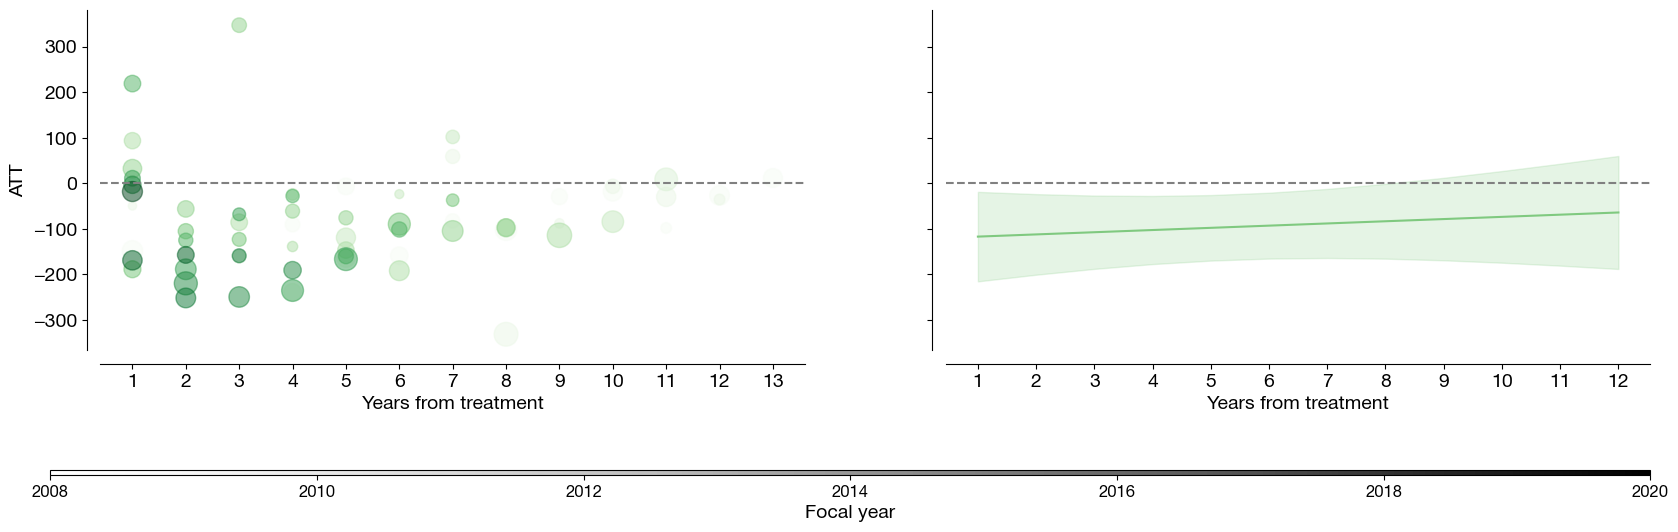

In [45]:
atts = pd.concat(list_results)

# Plot coefs and CIs for the different high classes and land types
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

plot_outcomes(
    dfs=[
        atts[(atts.land_type == "conifers") & (atts.lag > 0)],
    ],
    labels=["Conifers"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"ATT",
    ),
    ax=ax[0],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=False,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
    size="control_mean",
)

plot_outcomes(
    dfs=[
        atts[atts.land_type == "conifers_linear"],
    ],
    labels=["Conifers"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"ATT",
    ),
    ax=ax[1],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=True,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)


# Add a colorbar at the bottom outside the plot using the max and min of all the focal years
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.01])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=2008, vmax=2020)
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Focal year", fontsize=14)

# Resize the colorbar ticks
cbar.ax.tick_params(labelsize=12)

# Save to PDF
plt.savefig(
    "../figs/fig_results_att_all.pdf",
    bbox_inches="tight",
    dpi=400,
    transparent=True,
)

## Miscelaneous plots

In [ ]:
################################################################################
################ ESTIMATE EFFECTS OF EMISSIONS FOR CONIFERS ####################
################################################################################

df_dnbr = calculate_estimator(
    treatments=wide_treatments[wide_treatments.land_type == 2],
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr,
    focal_years=range(2008, 2022),
    outcome_var="dnbr",
    low_treatment_class={"dnbr": 1},
    pooling=pooling,
    cluster_var="year",
    formula="att ~ lag",
    max_lags=14,
)
df_dnbr["land_type"] = "conifers"

df_frp = calculate_estimator(
    treatments=wide_treatments_frp[wide_treatments_frp.land_type == 2],
    weights=conifers_loss["weights_dnbr"],
    outcomes=frp,
    focal_years=range(2008, 2022),
    outcome_var="frp",
    low_treatment_class={"frp": 1},
    pooling=pooling,
    cluster_var="year",
    formula="att ~ lag",
    max_lags=14,
)
df_frp["land_type"] = "conifers"

df_dnbr.to_csv("../data/results/att_conifers_dnbr.csv", index=False)
df_frp.to_csv("../data/results/att_conifers_frp.csv", index=False)